In [1]:
using Plots
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random 
using ArraysOfArrays
using ValueShapes
using Measurements
import BAT 
using MultivariateStats
using Clustering
using Measurements
using BenchmarkTools
using Parameters
using SpecialFunctions 

pyplot()

# using PyPlot

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278


Plots.PyPlotBackend()

# 1. Densities

Activate the desired distribution:  

## 1.1 Multivariate Normal Distribution:

In [72]:
# no correltions: 

n_dims = 80
σ = 1
distribution = BAT.MvNormal(n_dims,σ)

prior = BAT.NamedTupleDist(
    x = repeat([-30.0 .. 30.0], n_dims),
);

truth_int = 0.0 #log(1/60)*n_dims

0.0

## 1.3 Funnel Distribution: 

In [ ]:
n_dims = 20

distribution = BAT.FunnelDistribution(n=n_dims)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

truth_int = 0.0 #-log(10)*n_dims*2

## 1.4 Caushy Distribution: 

In [214]:
n_dims = 20

distribution = Product([truncated(Cauchy(), -20, 20) for i in 1:n_dims]) #BAT.MultimodalCauchy(n=n_dims);

prior = NamedTupleDist(
    x = repeat([-10.0 .. 10.0], n_dims),
);

truth_int = 0.0

0.0

## 1.5 Gaussian Shell: 

In [ ]:
n_dims = 10

distribution = BAT.GaussianShell(n=n_dims, r=10);

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

# truth_int = -log(10)*n_dims*2

truth_int = 0.0

# 2. Sampling

In [215]:
log_likelihood = let dist = distribution
    params -> begin
        BAT.LogDVal(logpdf(dist, params.x))
    end
end

posterior = BAT.PosteriorDensity(log_likelihood, prior);

In [216]:
nsamples = 10^6

1000000

In [217]:
samples = BAT.bat_sample(
    distribution, 
    BAT.IIDSampling(nsamples=nsamples)
).result; 

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/.julia/packages/BAT/6qNaJ/src/algotypes/bat_default.jl:44


In [218]:
# samples = BAT.bat_sample(
#     posterior, 
#     BAT.MCMCSampling(nsteps = 10^5, sampler = BAT.MetropolisHastings(), nchains = 4)
# ).result; 

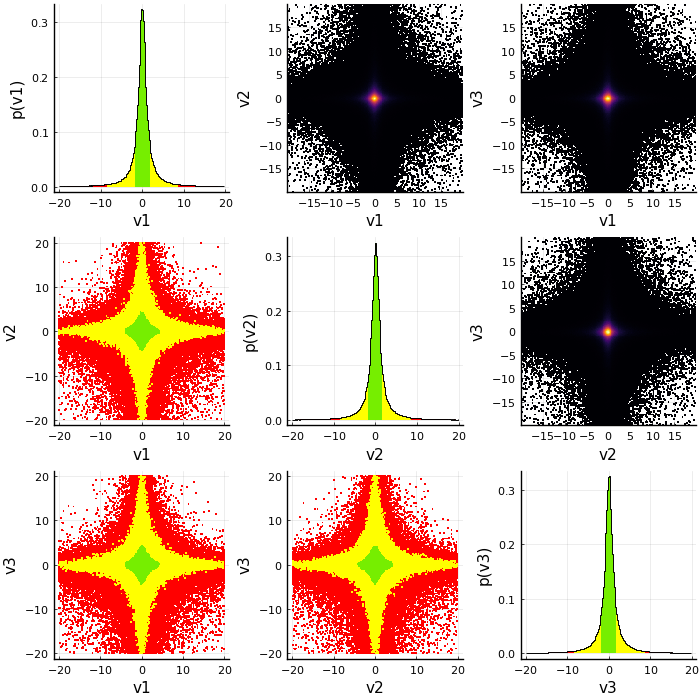

In [219]:
plot(samples, vsel=1:3, size=(700, 700))

# 3. Integration

In [220]:
include("../src/whitening.jl")
include("../src/clustering.jl")
include("../src/volumes.jl")
include("../src/integration.jl")

compute_hm

In [221]:
# whitening = Standardizing()
whitening = EigenDecompos()
# whitening = PartialEigenDecompos(steep_edges_ind = [])

clustering = KMeans(
    nclusters = [1, 2, 4, 8] 
)

# volumes = HyperRectangle()
volumes = HyperSpheres(α = 0.85, step = 0.9)

int_alg = AHMIntegration(whitening=whitening, clustering=clustering, volumes=volumes)

AHMIntegration{EigenDecompos,KMeans,HyperSpheres{Float64,Int64}}
  whitening: EigenDecompos EigenDecompos()
  clustering: KMeans
  volumes: HyperSpheres{Float64,Int64}


In [222]:
@time output = bat_integrate(samples, int_alg);

┌ Info: Iteration 1/4
└ @ Main /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/src/integration.jl:51
┌ Info: Iteration 2/4
└ @ Main /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/src/integration.jl:51
┌ Info: Iteration 3/4
└ @ Main /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/src/integration.jl:51
┌ Info: Iteration 4/4
└ @ Main /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/src/integration.jl:51


 33.587287 seconds (1.25 M allocations: 13.859 GiB, 14.59% gc time)


In [223]:
run_result = log(output.result)

-0.06 ± 0.12

In [224]:
rres = output.result

0.94 ± 0.12

In [225]:
run_int_estimates = output.log_estimates
run_log_vol = output.log_vol
deb = output.debug;

In [226]:
length(run_log_vol)

15

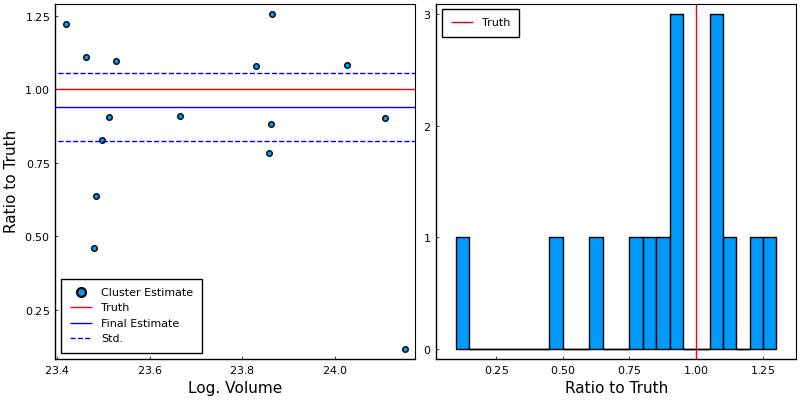

In [227]:
p1 = scatter(
    run_log_vol, 
    exp.(run_int_estimates .- truth_int), 
    label="Cluster Estimate",
    xlabel = "Log. Volume",
    ylabel = "Ratio to Truth", frame=true)

p1 = hline!([1], label="Truth", color="red",  ) # ylim=(0.90, 1.1)

p1 = hline!([exp.(run_result.val .- truth_int)], 
    label="Final Estimate", 
    color="blue")

p1 = hline!([rres.val - rres.err, rres.val + rres.err]./exp.(truth_int), 
    label="Std.", 
    color="blue", linestyle=:dash, grid=false)

p2 = histogram(exp.(run_int_estimates.-truth_int), nbins=30, 
    frame=true, 
    label="", 
    xlabel = "Ratio to Truth", )

p2 = vline!([1.0], label="Truth", color="red", grid=false)

plot(p1, p2, size=(800, 400))

In [228]:
# cl_ind = 5
# vls = deb[cl_ind].smpls
# cnt = deb[cl_ind].cl_center

# tmp = vec(sqrt.(sum((vls .- cnt).^2, dims=1)))

# histogram(tmp)

# # median(tmp, dims=2)

In [229]:
function make_debug_plot(data, ind; x=1, y=2)
    
    nt_data = data[ind].smpls
    clst_mask = data[ind].cl_mask
    clst_cent = data[ind].cl_center
    vol_mask = data[ind].volume
    
    p1 = scatter(nt_data[x, :], nt_data[y, :], color=palette(:Paired_3)[1], markersize=2, markerstrokewidth=0.0, label="Samples", frame=true, size=(500, 500))
    p1 = scatter!(nt_data[x, clst_mask], nt_data[y, clst_mask], color=palette(:OrRd_3)[2], markersize=2, markerstrokewidth=0.0, label="Cluster")
    p1 = scatter!(nt_data[x, vol_mask], nt_data[y, vol_mask], color=palette(:OrRd_3)[3], markersize=2, markerstrokewidth=0.0, label="Int. Volume", frame=true)
    p1 = scatter!([clst_cent[x]],[clst_cent[y]], color="black", markersize=10, markerstrokewidth=0.0, label="Cluster Center")
    p1 = plot!(xlabel=x, ylabel=y, grid=false)
    return p1
end

make_debug_plot (generic function with 1 method)

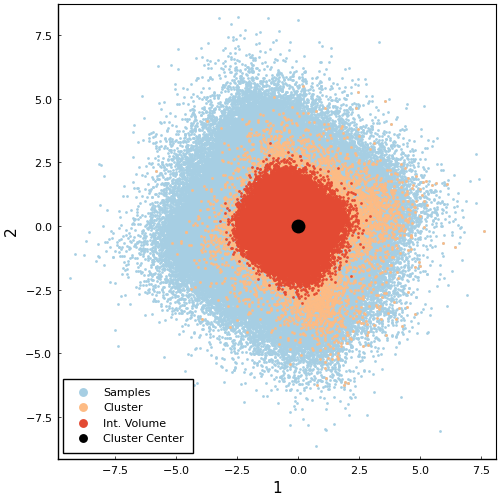

In [232]:
make_debug_plot(deb, 15)

In [231]:
function make_animation(data, ind; x=1, y=2, xrange=(-9, 9), yrange=(-9, 9))
    
    nt_data = data[ind].smpls
    clst_mask = data[ind].cl_mask
    clst_cent = data[ind].cl_center
    vol_mask = data[ind].volume
    
    p1 = scatter(nt_data[x, :], nt_data[y, :], color=palette(:Paired_3)[1], markersize=2, markerstrokewidth=0.0, label="Samples", frame=true, size=(500, 500))
    p1 = scatter!(nt_data[x, clst_mask], nt_data[y, clst_mask], color=palette(:OrRd_3)[2], markersize=2, markerstrokewidth=0.0, label="Cluster")
    p1 = scatter!(nt_data[x, vol_mask], nt_data[y, vol_mask], color=palette(:OrRd_3)[3], markersize=2, markerstrokewidth=0.0, label="Samples", frame=true)
    p1 = scatter!([clst_cent[x]],[clst_cent[y]], color="black", markersize=10, markerstrokewidth=0.0, label="Cluster Center")
    p1 = plot!(xlabel=x, ylabel=y, grid=false, xlim=xrange, ylim=yrange, legend=false)
    return p1
end

# anim = @animate for i in 1:30
#     make_animation(deb, i)
# end;

# gif(anim, "anim_fps15.gif", fps = 2)

    To do: 
    
    - Use threads/workers parallelization 
    - Think whether dataset splitting is needed 
    - Try different volumes